https://open-data-battle.geecko.com/issues/predict

# Predict

 В одной из компаний для найма сотрудников решили создать математическую модель, описывающую зависимость уровня заработной платы от опыта сотрудников. В файлах ‘inputs.npy’, ‘outputs.npy’ даны оценки заработной платы и опыта сотрудников, представленные в своих диапазонах и полученные в результате использования шкалы перевода.

В компании разработали простейшую нейронную сеть model с ошибкой loss. Обучи нейронную сеть предсказывать необходимые значения. В качестве ответа к заданию предскажи 5 точек [1, 2, 3, 4, 5] при помощи нейронной сети любой модели. Ответ выдайте в формате JSON: 

`{"answer": ["x1", "x2", ... "x5"]}`

## Загрузка данных

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
inputs = np.load('Data/inputs.npy')
print(inputs.shape, inputs[:5], sep='\n')

(1000,)
[-0.7150358 -1.7290071  1.9302819  1.9619546 -0.5580657]


In [9]:
outputs = np.load('Data\outputs.npy')
print(outputs.shape, outputs[:5], sep='\n')

(1000,)
[-2.350982  -6.686186  14.57553   15.004372  -2.2539327]


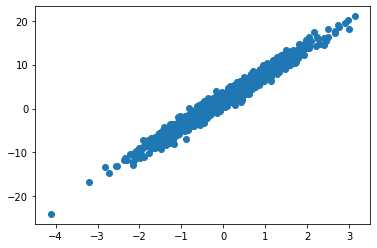

In [10]:
plt.scatter(inputs, outputs)

## Реализация градиентного спуска

### 1 способ

In [11]:
k = tf.Variable(0.0)
b = tf.Variable(0.0)

EPOCHS = 500
learning_rate = 0.02

list_loss = []
for n in range(EPOCHS):
    with tf.GradientTape() as t:
        f = k * inputs + b
        loss = tf.reduce_mean(tf.square(outputs - f))
        list_loss.append(loss.numpy())
         
    dk, db = t.gradient(loss, [k, b])
 
    k.assign_sub(learning_rate * dk)
    b.assign_sub(learning_rate * db)
    
print(k, b, sep="\n")    

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.9721303>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0731428>


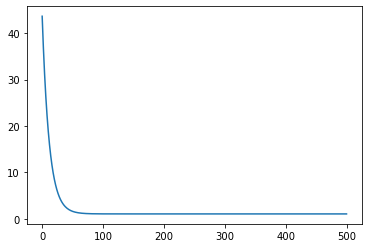

In [12]:
plt.plot(list_loss)

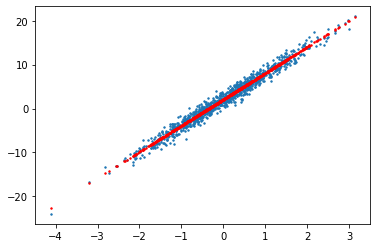

In [13]:
y_pr = k * inputs + b
plt.scatter(inputs, outputs, s=2)
plt.scatter(inputs, y_pr, c='r', s=2)
plt.show()

In [14]:
x_pred = range(1, 6)

In [15]:
y_pr = k * x_pred + b
answer = y_pr.numpy().tolist()
answer = {'answer': answer}
answer

{'answer': [8.045272827148438,
  14.017403602600098,
  19.989534378051758,
  25.9616641998291,
  31.933794021606445]}

In [16]:
import json

In [17]:
with open("predict.json", "w") as write_file:
    json.dump(answer, write_file)

### 2 способ

In [18]:
k = tf.Variable([[0.]])
b = tf.Variable([[0.0]])

In [19]:
EPOCHS = 500

opt = tf.optimizers.SGD(learning_rate=0.1)

for n in range(EPOCHS):
    with tf.GradientTape() as t:
        f = inputs.reshape(-1, 1) @ k + b
        loss = tf.reduce_mean(tf.square(outputs.reshape(-1, 1) - f))
        list_loss.append(loss.numpy())
         
    dk, db = t.gradient(loss, [k, b])
    opt.apply_gradients(zip([dk, db], [k, b]))
    
print(k, b, sep="\n")  

<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[5.972135]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[2.0731447]], dtype=float32)>


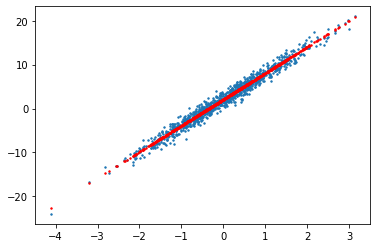

In [20]:
y_pr = k * inputs + b
plt.scatter(inputs, outputs, s=2)
plt.scatter(inputs, y_pr, c='r', s=2)
plt.show()

### 3 способ (сокращение 1 и 2 способов)

In [21]:
k = tf.Variable(0.0)
b = tf.Variable(0.0)
loss = lambda: tf.reduce_mean(tf.square(outputs - (k*inputs+b)))

opt = tf.optimizers.SGD(learning_rate=0.1)

for n in range(EPOCHS):
    opt.minimize(loss, [k, b])

print(k, b)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.972135> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0731447>


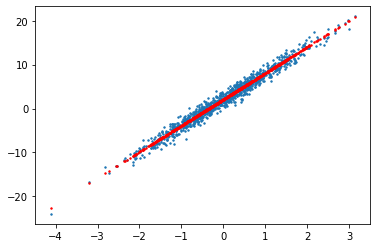

In [22]:
y_pr = k * inputs + b
plt.scatter(inputs, outputs, s=2)
plt.scatter(inputs, y_pr, c='r', s=2)
plt.show()

### 4 способ (через слой нейросети)

In [42]:
class DenseNN(tf.Module):
    """
        Класс для создания полносвязного слоя нейросети
    """
    def __init__(self, outputs):
        super().__init__()
        self.outputs = outputs  #количество выходов
        self.fl_init = False
 
    def __call__(self, x):
        #инициализация начальных значений
        if not self.fl_init:
            w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w")
            b = tf.zeros([self.outputs], dtype=tf.float32, name="b")
 
            self.w = tf.Variable(w)
            self.b = tf.Variable(b)
 
            self.fl_init = True
 
        y = x @ self.w + self.b
        return y

In [80]:
model = DenseNN(1)

In [44]:
loss = lambda x, y: tf.reduce_mean(tf.square(x - y))
opt = tf.optimizers.Adam(learning_rate=0.01)

In [81]:
x_train, y_train = inputs, outputs

In [88]:
x_train = tf.constant(x_train, shape=(len(x_train),1))
x_train[:2]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.7150358],
       [-1.7290071]], dtype=float32)>

In [85]:
EPOCHS = 50
for n in range(EPOCHS):
    for x, y in zip(x_train, y_train):
        x = tf.expand_dims(x, axis=0)
        with tf.GradientTape() as tape:
            f_loss = loss(y, model(x))
 
        # trainable_variables унаследовался от tf.Modele
        grads = tape.gradient(f_loss, model.trainable_variables) 
        opt.apply_gradients(zip(grads, model.trainable_variables))
        
print(f_loss.numpy())

0.7285463


In [86]:
b, w = model.trainable_variables

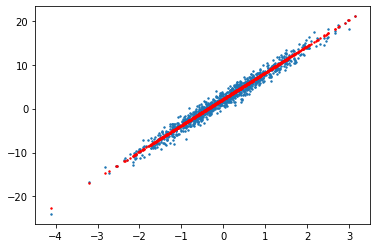

In [87]:
y_pr = w * inputs + b
plt.scatter(inputs, outputs, s=2)
plt.scatter(inputs, y_pr, c='r', s=2)
plt.show()